# PAMAP2 Physical Activity Monitoring データの分析サンプル（後半・途中までは前回説明済み）

### 準備作業（データ読み込み等）

必要なライブラリのインポート

In [1]:
from matplotlib import pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
import math
from sklearn.model_selection import train_test_split


すべてのファイルからデータを読み込み，データフレームを作成する．ここでは，ファイルをリスト化し，カラムの各列のヘッダを作成する．
##### ・ファイル名のリスト作成：各被験者のデータファイルを読み込むためにファイル名をリスト化
##### ・活動ラベルの辞書作成：各活動の番号（ラベル）と名前（例：1=lying，2=sitting）を辞書にマッピング
##### ・IMUカテゴリのリスト作成：各センサー（手首，胸，足首）のデータ列名を別々にリスト化
##### ・カラムコレクションの統合：タイムスタンプ，活動ラベル，心拍数，各IMUカテゴリのデータ列名をすべて結合し，データフレームのカラム名を作成
最後に，作成したヘッダに対して列数を表示する．各データファイルは54列あるので，それと等しくなっていればよい．

In [2]:
# Load data
list_of_files = ['PAMAP2_Dataset/Protocol/subject101.dat',
                 'PAMAP2_Dataset/Protocol/subject102.dat',
                 'PAMAP2_Dataset/Protocol/subject103.dat',
                 'PAMAP2_Dataset/Protocol/subject104.dat',
                 'PAMAP2_Dataset/Protocol/subject105.dat',
                 'PAMAP2_Dataset/Protocol/subject106.dat',
                 'PAMAP2_Dataset/Protocol/subject107.dat',
                 'PAMAP2_Dataset/Protocol/subject108.dat',
                 'PAMAP2_Dataset/Protocol/subject109.dat' ]

subjectID = [1,2,3,4,5,6,7,8,9]

activityIDdict = {0: 'transient',
              1: 'lying',
              2: 'sitting',
              3: 'standing',
              4: 'walking',
              5: 'running',
              6: 'cycling',
              7: 'Nordic_walking',
              9: 'watching_TV',
              10: 'computer_work',
              11: 'car driving',
              12: 'ascending_stairs',
              13: 'descending_stairs',
              16: 'vacuum_cleaning',
              17: 'ironing',
              18: 'folding_laundry',
              19: 'house_cleaning',
              20: 'playing_soccer',
              24: 'rope_jumping' }

colNames = ["timestamp", "activityID","heartrate"]

IMUhand = ['handTemperature', 
           'handAcc16_1', 'handAcc16_2', 'handAcc16_3', 
           'handAcc6_1', 'handAcc6_2', 'handAcc6_3', 
           'handGyro1', 'handGyro2', 'handGyro3', 
           'handMagne1', 'handMagne2', 'handMagne3',
           'handOrientation1', 'handOrientation2', 'handOrientation3', 'handOrientation4']

IMUchest = ['chestTemperature', 
           'chestAcc16_1', 'chestAcc16_2', 'chestAcc16_3', 
           'chestAcc6_1', 'chestAcc6_2', 'chestAcc6_3', 
           'chestGyro1', 'chestGyro2', 'chestGyro3', 
           'chestMagne1', 'chestMagne2', 'chestMagne3',
           'chestOrientation1', 'chestOrientation2', 'chestOrientation3', 'chestOrientation4']

IMUankle = ['ankleTemperature', 
           'ankleAcc16_1', 'ankleAcc16_2', 'ankleAcc16_3', 
           'ankleAcc6_1', 'ankleAcc6_2', 'ankleAcc6_3', 
           'ankleGyro1', 'ankleGyro2', 'ankleGyro3', 
           'ankleMagne1', 'ankleMagne2', 'ankleMagne3',
           'ankleOrientation1', 'ankleOrientation2', 'ankleOrientation3', 'ankleOrientation4']

columns = colNames + IMUhand + IMUchest + IMUankle  #all columns in one list

len(columns)


54

データファイルを読み込む．データファイルは，スペースで区切られているのでスペースごとに1行を読み込み，レコードを生成してデータフレームに保存している（保存の際に，ファイル名の数字部分から被験者ID：subject_id を生成して，データに付加している）．

In [3]:
dataCollection = pd.DataFrame()
for file in list_of_files:
    procData = pd.read_table(file, header=None, sep=r'\s+')
    procData.columns = columns
    procData['subject_id'] = int(file[-5])
    dataCollection = pd.concat([dataCollection, procData], ignore_index=True)

dataCollection.reset_index(drop=True, inplace=True)
dataCollection.head(10)

,timestamp,activityID,heartrate,handTemperature,handAcc16_1,handAcc16_2,handAcc16_3,handAcc6_1,handAcc6_2,handAcc6_3,...,ankleGyro2,ankleGyro3,ankleMagne1,ankleMagne2,ankleMagne3,ankleOrientation1,ankleOrientation2,ankleOrientation3,ankleOrientation4,subject_id
0,8.38,0,104.0,30.0,2.37223,8.60074,3.51048,2.43954,8.76165,3.35465,...,0.009250,-0.017580,-61.1888,-38.9599,-58.1438,1.0,0.0,0.0,0.0,1
1,8.39,0,NaN,30.0,2.18837,8.56560,3.66179,2.39494,8.55081,3.64207,...,-0.004638,0.000368,-59.8479,-38.8919,-58.5253,1.0,0.0,0.0,0.0,1
2,8.40,0,NaN,30.0,2.37357,8.60107,3.54898,2.30514,8.53644,3.73280,...,0.000148,0.022495,-60.7361,-39.4138,-58.3999,1.0,0.0,0.0,0.0,1
3,8.41,0,NaN,30.0,2.07473,8.52853,3.66021,2.33528,8.53622,3.73277,...,-0.020301,0.011275,-60.4091,-38.7635,-58.3956,1.0,0.0,0.0,0.0,1
4,8.42,0,NaN,30.0,2.22936,8.83122,3.70000,2.23055,8.59741,3.76295,...,-0.014303,-0.002823,-61.5199,-39.3879,-58.2694,1.0,0.0,0.0,0.0,1
5,8.43,0,NaN,30.0,2.29959,8.82929,3.54710,2.26132,8.65762,3.77788,...,-0.016024,0.001050,-60.2954,-38.8778,-58.3977,1.0,0.0,0.0,0.0,1
6,8.44,0,NaN,30.0,2.33738,8.82900,3.54767,2.27703,8.77828,3.73230,...,-0.053934,0.015594,-60.6307,-38.8676,-58.2711,1.0,0.0,0.0,0.0,1
7,8.45,0,NaN,30.0,2.37142,9.05500,3.39347,2.39786,8.89814,3.64131,...,-0.039937,-0.000785,-60.5171,-38.9819,-58.2733,1.0,0.0,0.0,0.0,1
8,8.46,0,NaN,30.0,2.33951,9.13251,3.54668,2.44371,8.98841,3.62596,...,-0.010042,0.017701,-61.2916,-39.6182,-58.1499,1.0,0.0,0.0,0.0,1
9,8.47,0,NaN,30.0,2.25966,9.09415,3.43015,2.42877,9.01871,3.61081,...,-0.013923,0.014498,-60.8509,-39.0821,-58.1478,1.0,0.0,0.0,0.0,1


上記のデータには，クリーニングしなければならないデータがある．たとえば，activityID が 0 のデータは，被験者が特定の活動をしていないことを示している．またいくつかの欠損値がある．

### データクレンジング

**PerformedActivitiesSummary.pdf** ファイルを参照すると，すべての被験者がすべての活動を行ったわけではない．したがって，欠損値が存在する．また，activityID が0 のデータは特定の活動をしていない．この値が変化していても，分析対象からは外す．次の順で実施するクレンジング用の関数を作成．
##### ・未使用のオリエンテーションデータレコード（3か所につき4種類ずつ）を削除
##### ・activityID が 0 のデータを削除
##### ・データ全体を数値化．数値化できないものは NaN に変換
##### ・NaN データ（欠損データ）を，前後のデータから補間（上端の欠損値はそのままになる）

In [4]:
def dataCleaning(dataCollection):
        dataCollection = dataCollection.drop(['handOrientation1', 'handOrientation2', 'handOrientation3', 'handOrientation4',
                                             'chestOrientation1', 'chestOrientation2', 'chestOrientation3', 'chestOrientation4',
                                             'ankleOrientation1', 'ankleOrientation2', 'ankleOrientation3', 'ankleOrientation4'],
                                             axis = 1)  # removal of orientation columns as they are not needed
        dataCollection = dataCollection.drop(dataCollection[dataCollection.activityID == 0].index) #removal of any row of activity 0 as it is transient activity which it is not used
        dataCollection = dataCollection.apply(pd.to_numeric, errors = 'coerce') #removal of non numeric data in cells
        dataCollection = dataCollection.interpolate() #removal of any remaining NaN value cells by constructing new data points in known set of data points
        
        return dataCollection

In [5]:
dataCol = dataCleaning(dataCollection)

In [6]:
dataCol.reset_index(drop = True, inplace = True)
dataCol.head(10)

,timestamp,activityID,heartrate,handTemperature,handAcc16_1,handAcc16_2,handAcc16_3,handAcc6_1,handAcc6_2,handAcc6_3,...,ankleAcc6_1,ankleAcc6_2,ankleAcc6_3,ankleGyro1,ankleGyro2,ankleGyro3,ankleMagne1,ankleMagne2,ankleMagne3,subject_id
0,37.66,1,NaN,30.375,2.21530,8.27915,5.58753,2.24689,8.55387,5.77143,...,9.63162,-1.76757,0.265761,0.002908,-0.027714,0.001752,-61.1081,-36.8636,-58.3696,1
1,37.67,1,NaN,30.375,2.29196,7.67288,5.74467,2.27373,8.14592,5.78739,...,9.58649,-1.75247,0.250816,0.020882,0.000945,0.006007,-60.8916,-36.3197,-58.3656,1
2,37.68,1,NaN,30.375,2.29090,7.14240,5.82342,2.26966,7.66268,5.78846,...,9.60196,-1.73721,0.356632,-0.035392,-0.052422,-0.004882,-60.3407,-35.7842,-58.6119,1
3,37.69,1,NaN,30.375,2.21800,7.14365,5.89930,2.22177,7.25535,5.88000,...,9.58674,-1.78264,0.311453,-0.032514,-0.018844,0.026950,-60.7646,-37.1028,-57.8799,1
4,37.70,1,100.0,30.375,2.30106,7.25857,6.09259,2.20720,7.24042,5.95555,...,9.64677,-1.75240,0.295902,0.001351,-0.048878,-0.006328,-60.2040,-37.1225,-57.8847,1
5,37.71,1,100.0,30.375,2.07165,7.25965,6.01218,2.19238,7.21038,6.01604,...,9.60177,-1.75239,0.311276,0.003793,-0.026906,0.004125,-61.3257,-36.9744,-57.7501,1
6,37.72,1,100.0,30.375,2.41148,7.59780,5.93915,2.23988,7.46679,6.03053,...,9.67694,-1.76748,0.326060,0.036814,-0.032277,-0.006866,-61.5520,-36.9632,-57.9957,1
7,37.73,1,100.0,30.375,2.32815,7.63431,5.70686,2.31663,7.64745,6.01495,...,9.61685,-1.76749,0.326380,-0.010352,-0.016621,0.006548,-61.5738,-36.1724,-59.3487,1
8,37.74,1,100.0,30.375,2.25096,7.78598,5.62821,2.28637,7.70801,5.93935,...,9.61686,-1.72212,0.326234,0.039346,0.020393,-0.011880,-61.7741,-37.1744,-58.1199,1
9,37.75,1,100.0,30.375,2.14107,7.52262,5.78141,2.31538,7.72276,5.78828,...,9.63189,-1.70699,0.326105,0.029874,-0.010763,0.005133,-60.7680,-37.4206,-58.8735,1


In [7]:
dataCol.isnull().sum()

timestamp           0
activityID          0
heartrate           4
handTemperature     0
handAcc16_1         0
handAcc16_2         0
handAcc16_3         0
handAcc6_1          0
handAcc6_2          0
handAcc6_3          0
handGyro1           0
handGyro2           0
handGyro3           0
handMagne1          0
handMagne2          0
handMagne3          0
chestTemperature    0
chestAcc16_1        0
chestAcc16_2        0
chestAcc16_3        0
chestAcc6_1         0
chestAcc6_2         0
chestAcc6_3         0
chestGyro1          0
chestGyro2          0
chestGyro3          0
chestMagne1         0
chestMagne2         0
chestMagne3         0
ankleTemperature    0
ankleAcc16_1        0
ankleAcc16_2        0
ankleAcc16_3        0
ankleAcc6_1         0
ankleAcc6_2         0
ankleAcc6_3         0
ankleGyro1          0
ankleGyro2          0
ankleGyro3          0
ankleMagne1         0
ankleMagne2         0
ankleMagne3         0
subject_id          0
dtype: int64

NaN のまま残っているのは，heartrate の 4 データであることが分かる（1 人目のデータの最初の4データ）．ここでは，5 行目以降のデータから同様に 100 を設定することが妥当そうなので，単純に 100 を代入する．

In [8]:
for i in range(0,4):
    dataCol.loc[i, "heartrate"]=100

これにより，欠損値はなくなる．

In [9]:
dataCol.isnull().sum()

timestamp           0
activityID          0
heartrate           0
handTemperature     0
handAcc16_1         0
handAcc16_2         0
handAcc16_3         0
handAcc6_1          0
handAcc6_2          0
handAcc6_3          0
handGyro1           0
handGyro2           0
handGyro3           0
handMagne1          0
handMagne2          0
handMagne3          0
chestTemperature    0
chestAcc16_1        0
chestAcc16_2        0
chestAcc16_3        0
chestAcc6_1         0
chestAcc6_2         0
chestAcc6_3         0
chestGyro1          0
chestGyro2          0
chestGyro3          0
chestMagne1         0
chestMagne2         0
chestMagne3         0
ankleTemperature    0
ankleAcc16_1        0
ankleAcc16_2        0
ankleAcc16_3        0
ankleAcc6_1         0
ankleAcc6_2         0
ankleAcc6_3         0
ankleGyro1          0
ankleGyro2          0
ankleGyro3          0
ankleMagne1         0
ankleMagne2         0
ankleMagne3         0
subject_id          0
dtype: int64

## 探索的データ分析

#### 教師データとテストデータに分割

データ分割の前に，データ数の偏りをなるべくなくす必要がある．各クラスの重みがアンバランスであれば，サンプリングを行う必要がある．クラスの割合が，80% 対 20% を超える場合は，明らかに不均衡．ここではそのような状態でないかをまず確認する． 

activityID ごとのデータ件数を可視化すると，次のようになる．

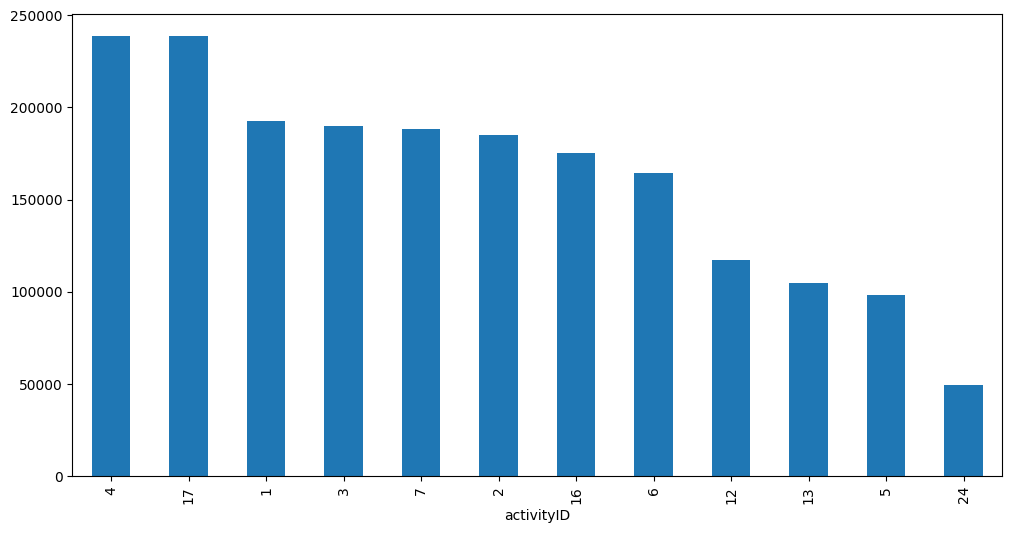

In [10]:
dataCol['activityID'].value_counts().plot(kind = "bar",figsize = (12,6))
plt.show()

これより，全体の80% を超えるクラスはなさそうなので，そのまま利用する．教師データとテストデータに分割．

In [11]:
train_df = dataCol.sample(frac=0.8, random_state=1)
test_df = dataCol.drop(train_df.index)

データが用意できていそうなことを，確認する．教師データ，テストデータそれぞれを表示．分布が大きく変わっていなければよい．

In [12]:
pd.options.display.float_format = '{:.2f}'.format
train_df.describe()

,timestamp,activityID,heartrate,handTemperature,handAcc16_1,handAcc16_2,handAcc16_3,handAcc6_1,handAcc6_2,handAcc6_3,...,ankleAcc6_1,ankleAcc6_2,ankleAcc6_3,ankleGyro1,ankleGyro2,ankleGyro3,ankleMagne1,ankleMagne2,ankleMagne3,subject_id
count,1554298.00,1554298.00,1554298.00,1554298.00,1554298.00,1554298.00,1554298.00,1554298.00,1554298.00,1554298.00,...,1554298.00,1554298.00,1554298.00,1554298.00,1554298.00,1554298.00,1554298.00,1554298.00,1554298.00,1554298.00
mean,1705.05,8.08,107.48,32.75,-4.95,3.58,3.60,-4.89,3.57,3.79,...,9.37,-0.04,-2.18,0.01,-0.04,0.01,-31.58,1.39,17.25,4.57
std,1093.59,6.18,26.99,1.79,6.24,6.89,3.96,6.25,6.59,3.95,...,6.07,7.18,3.48,1.13,0.64,2.01,18.35,21.68,19.69,2.33
min,31.20,1.00,57.00,24.88,-145.37,-104.30,-101.45,-61.21,-61.84,-61.93,...,-61.14,-61.90,-62.31,-14.16,-13.04,-14.02,-172.62,-137.91,-102.72,1.00
25%,744.29,3.00,86.00,31.69,-8.97,1.06,1.16,-8.87,1.06,1.37,...,8.40,-2.07,-3.40,-0.21,-0.11,-0.44,-41.70,-12.47,3.80,2.00
50%,1480.09,6.00,104.00,33.12,-5.45,3.53,3.43,-5.38,3.57,3.66,...,9.55,-0.23,-1.99,0.00,-0.00,-0.00,-34.00,0.77,18.77,5.00
75%,2664.00,13.00,124.00,34.06,-0.96,6.45,6.53,-0.91,6.46,6.78,...,10.28,1.92,-0.60,0.13,0.12,0.09,-17.90,17.83,31.21,7.00
max,4245.68,24.00,202.00,35.50,62.86,155.70,157.76,52.82,62.26,61.92,...,61.97,62.05,60.94,17.42,13.59,14.48,91.55,93.70,146.90,9.00


In [13]:
test_df.describe()

,timestamp,activityID,heartrate,handTemperature,handAcc16_1,handAcc16_2,handAcc16_3,handAcc6_1,handAcc6_2,handAcc6_3,...,ankleAcc6_1,ankleAcc6_2,ankleAcc6_3,ankleGyro1,ankleGyro2,ankleGyro3,ankleMagne1,ankleMagne2,ankleMagne3,subject_id
count,388574.00,388574.00,388574.00,388574.00,388574.00,388574.00,388574.00,388574.00,388574.00,388574.00,...,388574.00,388574.00,388574.00,388574.00,388574.00,388574.00,388574.00,388574.00,388574.00,388574.00
mean,1705.81,8.09,107.54,32.75,-4.95,3.60,3.60,-4.89,3.58,3.78,...,9.39,-0.05,-2.17,0.01,-0.04,0.01,-31.63,1.41,17.25,4.57
std,1092.95,6.17,27.00,1.79,6.24,6.92,3.95,6.25,6.61,3.93,...,6.07,7.22,3.47,1.13,0.64,2.02,18.34,21.70,19.76,2.33
min,31.29,1.00,57.00,24.88,-103.96,-80.98,-73.26,-60.97,-61.81,-61.58,...,-58.43,-61.91,-62.29,-24.00,-18.13,-11.74,-172.87,-136.93,-100.86,1.00
25%,745.46,3.00,86.00,31.62,-8.97,1.06,1.16,-8.86,1.07,1.36,...,8.43,-2.08,-3.40,-0.21,-0.11,-0.44,-41.78,-12.55,3.77,2.00
50%,1481.39,6.00,105.00,33.12,-5.45,3.53,3.43,-5.38,3.57,3.66,...,9.56,-0.22,-1.99,0.00,-0.00,-0.00,-34.04,0.81,18.76,5.00
75%,2662.13,13.00,124.00,34.06,-0.96,6.46,6.52,-0.90,6.46,6.77,...,10.31,1.92,-0.59,0.13,0.12,0.09,-18.01,17.88,31.23,7.00
max,4245.63,24.00,202.00,35.50,46.74,155.53,85.78,46.21,62.25,60.84,...,61.94,62.04,58.69,11.61,9.01,16.53,81.50,94.25,146.65,9.00


心拍数は，被験者の状態を追跡するための重要な要素なので，どれくらいの分布をしているかを箱ひげ図で可視化．そのまえに，箱ひげ図や後で出てくるヒートマップを描画するライブラリをインストール．

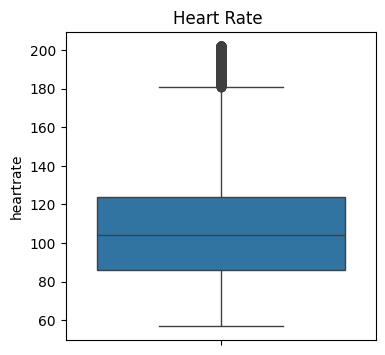

In [14]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(4,4))
plt.title("Heart Rate ")
ax = sns.boxplot(y=train_df["heartrate"])

心拍数の箱ひげ図より，心拍数が180 を超える外れ値が存在していることがわかる．これらは非常に高い心拍数で，非常に激しいアクティビティや異常値である可能性がある．

最も負担の大きいアクティビティを見つけるために，各アクティビティごとの平均心拍数を示す棒グラフを描画．どのアクティビティが最も心拍数が高いか，つまり最も負担が大きいアクティビティを見つけることに利用できる．

<Axes: xlabel='activityID'>

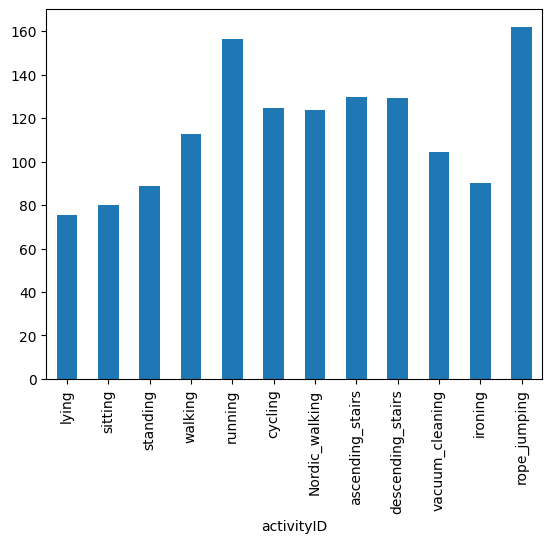

In [15]:
df_hr_act = train_df['heartrate'].groupby(train_df['activityID']).mean()
df_hr_act.index = df_hr_act.index.map(activityIDdict)
df_hr_act.plot(kind='bar')

この棒グラフからは，ランニングと縄跳びが心拍数への負荷が高そうなことが分かる．それらが他の活動に対して有意差があるかどうかは，後で確認する．

次にデータの異常や相関関係を調べるために，相関係数を求めてからヒートマップを作成する．

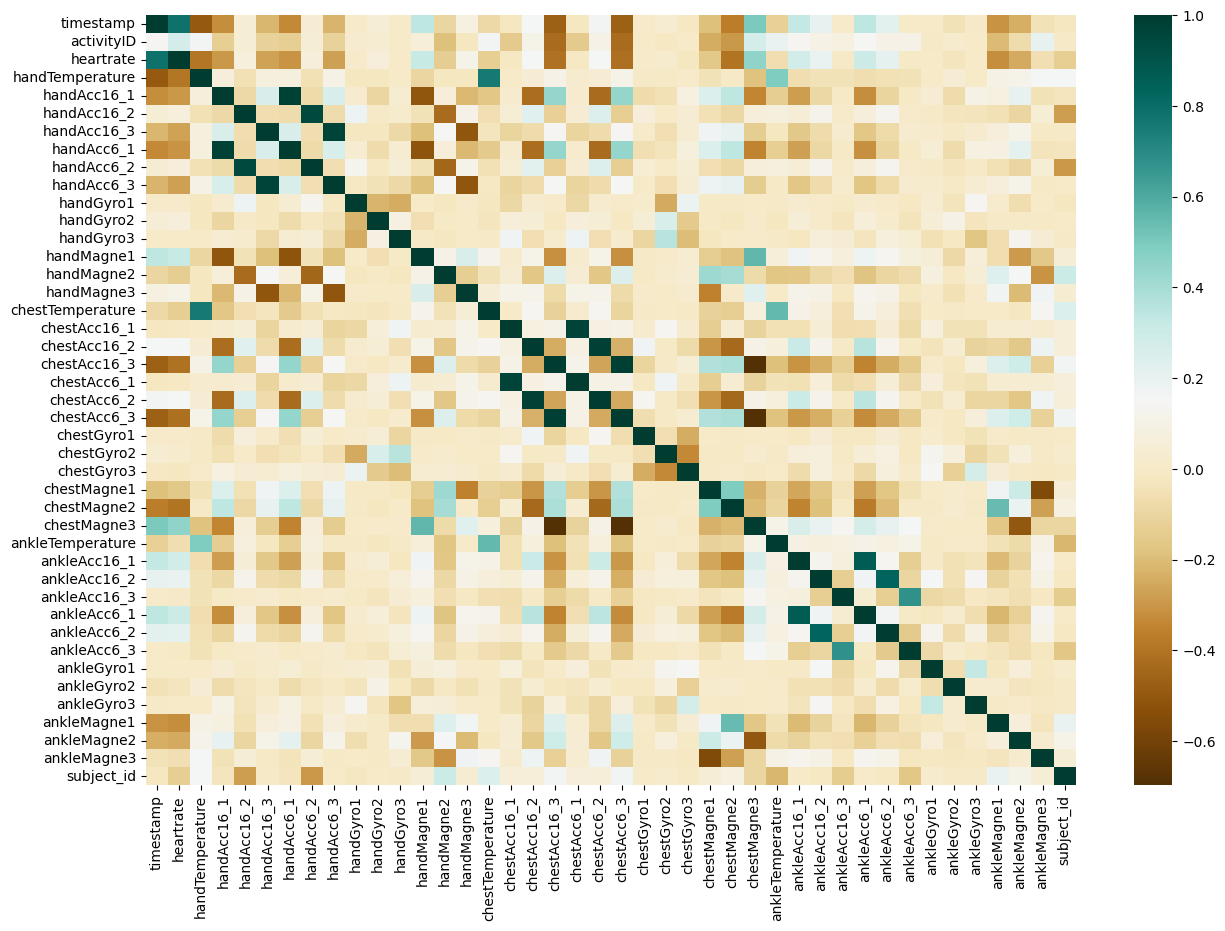

In [16]:
from pandas.plotting import scatter_matrix
df_corr = train_df.corr()
df_corr = df_corr.drop(['activityID'], axis = 1)

f, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(df_corr, mask=np.zeros_like(df_corr, dtype=np.bool), cmap = "BrBG",ax=ax)
plt.show()

このヒートマップからは次のことが分かる（次は一例）：
##### ・ジャイロスコープのデータはほかのどのデータともあまり関係していないように見え，この分析では不要．
##### ・心拍数と各部位の加速度計には相関がある．足首の加速度計とは正の相関，それ以外の部分とは負の相関．
##### ・心拍数と各部位の磁力計には相関がある．足首の磁力計とは負の相関，それ以外の部分とは正の相関．
##### → 上半身の身体活動は心拍数を上げて，下半身は下げる？

## 仮説の検定

最も負荷の高い活動は，ランニングと縄跳び．それらが他の活動と差があるかどうかを検定する．

**帰無仮説: **
- h0 : 負荷の高い活動の心拍数の平均値は，すべての活動に対して有意な差がない

**対立仮説: **

- h1 : 負荷の高い活動の心拍数の平均値は，すべての活動に対して大きく異なる

まず，ランニング(5) と縄跳び(24) のデータを取り出す．

In [17]:
running_data = train_df.loc[(train_df["activityID"] == 5)]
ropejumping_data = train_df.loc[(train_df["activityID"] == 24)]
cumbersome_data = pd.concat([running_data,ropejumping_data])

それ以外のデータを取り出す．

In [18]:
other_data = train_df.loc[(train_df["activityID"] != 5)]
other_data = other_data.loc[(other_data["activityID"] != 24)]

t検定を行い，p値を算出する．

In [19]:
import scipy.stats
stat, pValue = scipy.stats.ttest_ind(cumbersome_data['heartrate'], other_data['heartrate'], equal_var=False)

In [20]:
if pValue > 0.1:
    print("p値は", pValue, "で，対立仮説 h1 が棄却されました．負荷の高い活動の心拍数の平均値は，すべての活動に対して有意な差がありません．")
else:
    print("p値は", pValue, "で，帰無仮説 h0 が棄却されました．負荷の高い活動の心拍数の平均値は，すべての活動に対して大きく異なります．")

p値は 0.0 で，帰無仮説 h0 が棄却されました．負荷の高い活動の心拍数の平均値は，すべての活動に対して大きく異なります．


## モデリング（ここから後半）

モデルを作成するにあたって，その精度に影響を与える不要な値を除去する．タイムスタンプと subject_id （誰のデータか）ということはモデルに関係ないので，ここでは削除する．

In [21]:
train_df = train_df.drop(["timestamp", "subject_id"],axis=1)
test_df = test_df.drop(["timestamp", "subject_id"],axis=1)

必要なライブラリをインポートする．

In [22]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split,cross_val_score,StratifiedShuffleSplit
from sklearn.metrics import precision_score,recall_score, f1_score, confusion_matrix,roc_auc_score,roc_curve, accuracy_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

データがその種類によって値の大きさがまちまちなので，標準化をする．標準化の際には，外れ値の影響を受けることがある．そこで外れ値の影響を受けづらい標準化方法（中央値と四分位数を利用する）である RobustScaler を利用する．
なお，標準化の際には中央値との差を第3四分位と第1四分位の差で割るので，値域はそれらの値により決定する．

In [23]:
#apply scaling to all columns except subject and activity 
scaler = RobustScaler()
df_scaled = train_df.copy()
df_scaled_test = test_df.copy()

df_scaled.iloc[:,1:41] = scaler.fit_transform(df_scaled.iloc[:,1:41])
df_scaled_test.iloc[:,1:41] = scaler.fit_transform(df_scaled_test.iloc[:,1:41])

標準化後のデータを表示する．

In [24]:
df_scaled.head()

,activityID,heartrate,handTemperature,handAcc16_1,handAcc16_2,handAcc16_3,handAcc6_1,handAcc6_2,handAcc6_3,handGyro1,...,ankleAcc16_3,ankleAcc6_1,ankleAcc6_2,ankleAcc6_3,ankleGyro1,ankleGyro2,ankleGyro3,ankleMagne1,ankleMagne2,ankleMagne3
312921,3,-0.37,0.45,-0.38,0.22,-0.57,-0.36,0.26,-0.53,-0.01,...,0.32,0.09,-0.32,0.35,0.22,0.00,-0.14,0.64,-0.58,0.66
141735,12,1.68,0.24,-0.72,-0.10,-0.21,-0.63,-0.11,-0.25,-0.87,...,0.02,0.84,-0.27,-0.19,-0.83,3.02,-0.27,-0.74,1.09,-0.92
1191085,24,2.03,0.29,0.46,0.04,-2.02,0.60,0.07,-1.45,-5.19,...,1.91,-7.26,-0.95,1.48,5.52,-0.77,-1.22,-0.45,-0.43,-0.67
1206914,1,-1.11,0.13,1.29,-0.69,0.90,1.32,-0.72,0.91,0.07,...,-0.35,-5.13,-2.30,-0.30,-0.04,0.03,0.04,0.70,0.85,-0.86
1710520,2,-0.66,0.50,0.43,-2.41,-0.47,0.45,-2.41,-0.48,-0.02,...,-0.11,-0.19,0.78,-0.06,0.02,0.07,0.06,0.61,0.50,0.26


In [25]:
df_scaled_test.head()

,activityID,heartrate,handTemperature,handAcc16_1,handAcc16_2,handAcc16_3,handAcc6_1,handAcc6_2,handAcc6_3,handGyro1,...,ankleAcc16_3,ankleAcc6_1,ankleAcc6_2,ankleAcc6_3,ankleGyro1,ankleGyro2,ankleGyro3,ankleMagne1,ankleMagne2,ankleMagne3
22,1,-0.13,-1.13,0.95,0.88,0.53,0.95,0.79,0.52,0.42,...,0.82,0.02,-0.39,0.82,-0.00,0.06,0.02,-1.12,-1.24,-2.81
30,1,-0.13,-1.13,0.96,0.75,0.45,0.95,0.72,0.44,0.45,...,0.88,0.04,-0.40,0.79,0.06,0.01,0.01,-1.14,-1.22,-2.82
40,1,-0.12,-1.13,1.00,0.65,0.46,1.00,0.67,0.46,-0.46,...,0.89,0.03,-0.38,0.82,-0.12,0.08,-0.02,-1.13,-1.27,-2.81
41,1,-0.12,-1.13,1.02,0.63,0.49,1.01,0.64,0.46,-0.37,...,0.91,0.05,-0.37,0.85,0.07,-0.03,-0.02,-1.14,-1.24,-2.83
43,1,-0.12,-1.13,0.99,0.57,0.47,1.00,0.57,0.42,-0.06,...,0.85,0.03,-0.37,0.82,0.05,-0.09,0.08,-1.14,-1.23,-2.81


In [26]:
X_train = df_scaled.drop('activityID', axis=1).values
y_train = df_scaled['activityID'].values

# Test Dataset
X_test = df_scaled_test.drop('activityID', axis=1).values
y_test = df_scaled_test['activityID'].values

### 主成分分析(PCA)を用いた次元削減

41個の説明変数（41次元）すべてがデータの説明に必要ではなく，分散の 90 ～ 98% が説明できれば良い（現に，一部の説明変数は心拍数にあまり関係なく，結果的に activityID にも関係ないことに注意）．主成分分析を行い，グラフを用いて表現．中間の 94% の値を表現できる説明変数の数を確認する．
グラフより，17個くらいの説明変数で説明可能なことが分かる．

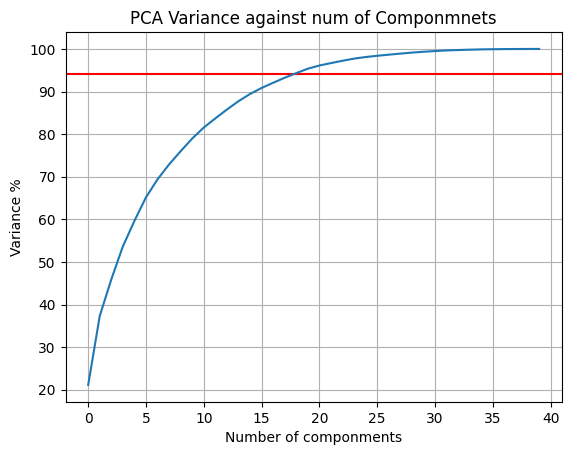

In [27]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(X_train)
# pca.explained_variance_ratio_ は各要素の割合．次の行で有効数字4桁で累積値を求めて，100 % に変換している．
var=np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)

plt.title("PCA Variance against num of Componmnets")
plt.ylabel("Variance %")
plt.xlabel("Number of componments")
# 94 % に赤い線を引く
l = plt.axhline(94, color="red")

plt.plot(var)
plt.grid()

PCA の結果として，各データを17次元に削減する．

In [28]:
pca = PCA(n_components=17)
X_train=pca.fit_transform(X_train)
X_test=pca.fit_transform(X_test)

17次元になっていることを確認する．

In [29]:
# トレーニングデータの1件目だけ表示
print(X_train[0])
print(len(X_train[0]))

[ 0.41229378 -0.06271397 -0.00789412  0.05519919 -0.1795141  -0.26749765
 -0.06973056  1.26539952  0.38357832  0.38662051 -0.59476691 -0.10850113
  0.33446158  0.15083688 -0.8089523   0.02803506 -0.32322151]
17


### 予測モデルの選択
予測パフォーマンスの高いモデルを選択する．ここでは，ランダムフォレストと，ロジスティック回帰を比較する．

一般的に，ランダムフォレストは精度が高く，高次元データセットでもパフォーマンスが高く，過学習になりにくい．  
一方でロジスティック回帰は，モデルが解釈しやすく，計算コストが低く大規模データに向く．線形関係を仮定できるときに，効果的．

精度を表示する関数の定義：

In [30]:
def get_metrics (y_true,y_pred):
    acc = accuracy_score(y_true, y_pred)
    err = 1-acc
    p = precision_score(y_true, y_pred,average=None).mean()
    r = recall_score(y_true, y_pred, average=None).mean()
    f1 = f1_score(y_true, y_pred, average=None).mean()
    
    print("Accuracy: %.3f \nError: %.3f \nPrecesion: %.3f \nRecall: %.3f \nF1:%.3f \n"% (acc,err,p,r,f1) )

ロジスティック回帰によるモデルの作成．

In [31]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression()
log_reg.fit(X=X_train, y=y_train )
y_pred_lr = log_reg.predict(X_test)
get_metrics(y_test, y_pred_lr)

Accuracy: 0.489 
Error: 0.511 
Precesion: 0.465 
Recall: 0.420 
F1:0.416 



ランダムフォレストによるモデルの作成（CPU コアを 4つ使用する）．モデル作成に相当の時間を要するので注意．

In [32]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_jobs =4)
rfc.fit(X_train,y_train)
y_pred_rf = rfc.predict(X_test)
get_metrics(y_test,y_pred_rf)

Accuracy: 0.967 
Error: 0.033 
Precesion: 0.968 
Recall: 0.961 
F1:0.964 



精度がランダムフォレストの方が高そうなので，そちらを利用する．

各要素に対して個別に予測する場合，次のように行う（1個目の要素，2個目の要素，．．．．最後の要素）．

In [33]:
print(rfc.predict_proba([X_test[0]]))
print(rfc.predict_proba([X_test[1]]))
print(rfc.predict_proba([X_test[-1]]))

[[0.56 0.06 0.22 0.   0.01 0.03 0.   0.03 0.   0.04 0.04 0.01]]
[[0.69 0.07 0.15 0.01 0.   0.04 0.   0.   0.   0.   0.03 0.01]]
[[0.01 0.01 0.   0.   0.   0.   0.01 0.   0.04 0.02 0.   0.91]]


上記の結果は，12種類のactivityIDに対する予測の確率．
テストデータの実際の結果を見ると，予測が正しそうなことが分かる．

In [34]:
print(y_test)

[ 1  1  1 ... 24 24 24]


###  クロスバリデーション

ここでは，両方のモデルのパフォーマンスを，10分割クロスバリデーションで確認する（非常に時間がかかる：参考 6時間ほどかかった）．  
それぞれの，精度，平均二乗誤差，F1 値を算出する．

In [35]:
import datetime
dt_before = datetime.datetime.now()

In [36]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

classifiers = [LogisticRegression(),
               RandomForestClassifier(n_jobs =4)]

score_lst = []
for cls in classifiers:
    accs  = accuracy_score(y_train, cross_val_predict(cls,X_train,y_train,cv = 10))  #cross validate the accurancy 
    scores = cross_val_score(cls,X_train,y_train,scoring = "neg_mean_squared_error",cv= 10)#calcuate the error
    score = np.sqrt(-scores)
    f1 = cross_val_score(cls,X_test, y_test,scoring = "f1_macro", cv =10)
    
    score_lst.append([cls.__class__.__name__,accs,score.mean(), f1.mean()])

df_scores=pd.DataFrame(columns = ["Claasifier","Accurancy","MSE","F1"],data =  score_lst)
display(df_scores)

,Claasifier,Accurancy,MSE,F1
0,LogisticRegression,0.49,6.20,0.37
1,RandomForestClassifier,0.97,1.45,0.78


In [37]:
dt_now = datetime.datetime.now()
print(dt_now - dt_before)

5:45:51.772573


結果は次のようになる：
|   | Claasifier | Accurancy | MSE | F1 |
| ---- | ---- | ---- | ---- | ---- |
| 0 | LogisticRegression | 0.49 | 6.20 | 0.37 |
| 1 | RandomForestClassifier | 0.97 | 1.44 | 0.78 |